# Recursive Neural Networks (RNNs) Exercises

These exercises is separated into a coding and a theory component.

For the first part, you will use the Google Speech Commands v0.02 subset (https://www.doc.ic.ac.uk/~jc3417/RNNs_Exercises/).

### Part 1 - Coding 
In this part you will have to:

#### Part 1.1

Implement the LSTM RNN cell.

#### Part 1.2

- Modify the RNNModel class, such that it is a Bidirectional RNN.
- Compare vanilla RNN, GRU, LSTM, and bidirectional VS unidirectional RNNs and report their performance with respect to accuracy and time cost.

#### Part 1.3

Then for your best model you will perform some improvements:
- In terms of architecture optimisation (number of layers, hidden state dimension)
- Better utilisation of the hidden state sequence output by the RNN, for classification.
- Report the improvements you achieved, as well as an explanation for why they worked.

### Part 2 - Theory

Here you will answer some theoretical questions about RNN training, and CTC -- no detailed proofs and no programming.

### Part 1: Coding

### Dataset

We will be using the Google [*Speech Commands*](https://www.tensorflow.org/tutorials/sequences/audio_recognition) v0.02 [1] dataset.

[1] Warden, P. (2018). [Speech commands: A dataset for limited-vocabulary speech recognition](https://arxiv.org/abs/1804.03209). *arXiv preprint arXiv:1804.03209.*

For the first part, you will use the Google Speech Commands v0.02 subset (https://www.doc.ic.ac.uk/~jc3417/RNNs_Exercises/).

Set-up code and imports

In [16]:
import math
import os
from collections import defaultdict

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
import numpy as np
from scipy.io.wavfile import read
import librosa
from matplotlib import pyplot as plt

cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Data provider class definition.

Here you can give different configuration to the [mfcc function](https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html). Additional keyword arguments are defined in the [melspectrogram function](https://librosa.github.io/librosa/generated/librosa.feature.melspectrogram.html#librosa.feature.melspectrogram).

One may additionally consider standardising the samples (remove mean, divide by std) or performing data augmentation, e.g., by adding low variance white or noise.

In [17]:
class SpeechCommandsDataset(Dataset):
    """Google Speech Commands dataset."""

    def __init__(self, root_dir, split):
        """
        Args:
            root_dir (string): Directory with all the data files.
            split    (string): In ["train", "valid", "test"].
        """
        self.root_dir = root_dir
        self.split = split

        self.number_of_classes = len(self.get_classes())

        self.class_to_file = defaultdict(list)

        self.valid_filenames = self.get_valid_filenames()
        self.test_filenames = self.get_test_filenames()

        for c in self.get_classes():
            file_name_list = sorted(os.listdir(self.root_dir + "/data_speech_commands_v0.02/" + c))
            for filename in file_name_list:
                if split == "train":
                    if (filename not in self.valid_filenames[c]) and (filename not in self.test_filenames[c]):
                        self.class_to_file[c].append(filename)
                elif split == "valid":
                    if filename in self.valid_filenames[c]:
                        self.class_to_file[c].append(filename)
                elif split == "test":
                    if filename in self.test_filenames[c]:
                        self.class_to_file[c].append(filename)
                else:
                    raise ValueError("Invalid split name.")

        self.filepath_list = list()
        self.label_list = list()
        for cc, c in enumerate(self.get_classes()):
            f_extension = sorted(list(self.class_to_file[c]))
            l_extension = [cc for i in f_extension]
            f_extension = [self.root_dir + "/data_speech_commands_v0.02/" + c + "/" + filename for filename in f_extension]
            self.filepath_list.extend(f_extension)
            self.label_list.extend(l_extension)
        self.number_of_samples = len(self.filepath_list)

    def __len__(self):
        return self.number_of_samples

    def __getitem__(self, idx):
        sample = np.zeros((16000, ), dtype=np.float32)

        sample_file = self.filepath_list[idx]

        sample_from_file = read(sample_file)[1]
        sample[:sample_from_file.size] = sample_from_file
        sample = sample.reshape((16000, ))
        
        ########################################################################
        ## YOU MAY CONFIGURE HERE.
        ########################################################################
        sample = librosa.feature.mfcc(y=sample, sr=16000, hop_length=512, n_fft=2048).transpose().astype(np.float32)
        ########################################################################
        ## DO NOT CONFIGURE BEYOND HERE.
        ########################################################################
        
        label = self.label_list[idx]

        return sample, label

    def get_classes(self):
        return ['one', 'two', 'three']

    def get_valid_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "/data_speech_commands_v0.02/validation_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

    def get_test_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "/data_speech_commands_v0.02/testing_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

Load Dataset - you may vary batch size.

In [18]:
## MAKE SURE THIS POINTS INSIDE THE DATASET FOLDER.
dataset_folder = "/data" # this should change depending on where you have stored the data files

train_dataset = SpeechCommandsDataset(dataset_folder,
                                      "train")
valid_dataset = SpeechCommandsDataset(dataset_folder,
                                      "valid")

test_dataset = SpeechCommandsDataset(dataset_folder,
                                     "test")

## YOU MAY CHANGE THE BATCH SIZE.
batch_size = 100


num_epochs = 5
valid_every_n_steps = 20
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

## Part 1.1

Finalise the LSTM cell (you can base your code on that of the GRU cell).

You are allowed to use nn.Linear.

In [19]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)
            hx = (hx, hx)
            
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        return (hy, cy)

class BasicRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True, nonlinearity="tanh"):
        super(BasicRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.nonlinearity = nonlinearity
        if self.nonlinearity not in ["tanh", "relu"]:
            raise ValueError("Invalid nonlinearity selected for RNN.")

        self.x2h = nn.Linear(input_size, hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=bias)

        self.reset_parameters()
        

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

            
    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
            
        return hy

    
    
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
     
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        self.reset_parameters()
        

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        return hy

In [20]:
class RNNModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size):
        super(RNNModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        
        self.rnn_cell_list = nn.ModuleList()
        
        if mode == 'LSTM':
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
           
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################


        elif mode == 'GRU':
            self.rnn_cell_list.append(GRUCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                                  self.hidden_size,
                                                  self.bias))

        elif mode == 'RNN_TANH':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "tanh"))

        elif mode == 'RNN_RELU':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
        else:
            raise ValueError("Invalid RNN mode selected.")


        self.att_fc = nn.Linear(self.hidden_size, 1)
        self.fc = nn.Linear(self.hidden_size, self.output_size)

        
    def forward(self, input, hx=None):
        if hx is None:
            if torch.cuda.is_available():
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
            else:
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))

        else:
             h0 = hx

        outs = []

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
    
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        out = outs[-1].squeeze() # Related to question 10.

        out = self.fc(out)
        
        
        return out
    

class BidirRecurrentModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size):
        super(BidirRecurrentModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        
        self.rnn_cell_list = nn.ModuleList()
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
  
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        
    def forward(self, input, hx=None):
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
        else:
            h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
            
        if torch.cuda.is_available():
            hT = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
        else:
            hT = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
            
            
        outs = []
        outs_rev = []
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        out = outs[-1].squeeze()  # Related to question 10.
        out_rev = outs_rev[0].squeeze()
        out = torch.cat((out, out_rev), 1)

        out = self.fc(out)
        return out

## Part 1.2

In the following, experiment with different RNN architectures (RNN cell types, number of layers, hidden state dimensionality, MFCC configuration, unidirectional VS bidirectional) and report the accuracy (pay also attention to the training and validation cost), as well as training time. 

* What are your justifications for these results?

* On the notebook, leave the execution of your best model.

In [20]:
# Parts of experiment code based on: https://github.com/emadRad/lstm-gru-pytorch

seq_dim, input_dim = train_dataset[0][0].shape
output_dim = 3

## YOU MAY CONFIGURE THESE.
hidden_dim = 32
layer_dim = 1
bias = True

model = RNNModel("GRU", input_dim, hidden_dim, layer_dim, bias, output_dim)
# model = BidirRecurrentModel("GRU", input_dim, hidden_dim, layer_dim, bias, output_dim)

if torch.cuda.is_available():
    model.cuda()
    
criterion = nn.CrossEntropyLoss()

## YOU MAY CONFIGURE THESE.
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list = []
iter = 0
max_v_accuracy = 0
reported_t_accuracy = 0
max_t_accuracy = 0
for epoch in range(num_epochs):
    for i, (audio, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            audio = Variable(audio.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer.zero_grad()

        outputs = model(audio)

        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()

        optimizer.step()

        loss_list.append(loss.item())
        iter += 1

        if iter % valid_every_n_steps == 0:
            correct = 0
            total = 0
            for audio, labels in valid_loader:
                if torch.cuda.is_available():
                    audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                else:
                    audio = Variable(audio.view(-1, seq_dim, input_dim))

                outputs = model(audio)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            v_accuracy = 100 * correct / total
            
            is_best = False
            if v_accuracy >= max_v_accuracy:
                max_v_accuracy = v_accuracy
                is_best = True

            if is_best:
                for audio, labels in test_loader:
                    if torch.cuda.is_available():
                        audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                    else:
                        audio = Variable(audio.view(-1, seq_dim, input_dim))

                    outputs = model(audio)

                    _, predicted = torch.max(outputs.data, 1)

                    total += labels.size(0)

                    if torch.cuda.is_available():
                        correct += (predicted.cpu() == labels.cpu()).sum()
                    else:
                        correct += (predicted == labels).sum()

                t_accuracy = 100 * correct / total
                reported_t_accuracy = t_accuracy

            print('Iteration: {}. Loss: {}. V-Accuracy: {}  T-Accuracy: {}'.format(iter, loss.item(), v_accuracy, reported_t_accuracy))



## Part 1.3

RNN hidden state. In the code above in the RNNModel and BidirRecurrentModel, we utilise the final hidden state extracted by the model in order to make the final pass through a feed-forward layer towards a final prediction.

a) Can you think of reasons this might not be the best choice? Please write down two variations that could possibly yield better result.

b) Experiment with such alternative approaches in the code below in order to achieve a better result and report it below.

* Your answer here.

In [ ]:
# Parts of experiment code based on: https://github.com/emadRad/lstm-gru-pytorch

# Add the model that has got the best results for you after after Part 1.2 and Part 1.3

seq_dim, input_dim = train_dataset[0][0].shape
output_dim = 3

## YOU MAY CONFIGURE THESE.
hidden_dim = 32
layer_dim = 1
bias = True

model = RNNModel("GRU", input_dim, hidden_dim, layer_dim, bias, output_dim)
# model = BidirRecurrentModel("GRU", input_dim, hidden_dim, layer_dim, bias, output_dim)

if torch.cuda.is_available():
    model.cuda()
    
criterion = nn.CrossEntropyLoss()

## YOU MAY CONFIGURE THESE.
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list = []
iter = 0
max_v_accuracy = 0
reported_t_accuracy = 0
max_t_accuracy = 0
for epoch in range(num_epochs):
    for i, (audio, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            audio = Variable(audio.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer.zero_grad()

        outputs = model(audio)

        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()

        optimizer.step()

        loss_list.append(loss.item())
        iter += 1

        if iter % valid_every_n_steps == 0:
            correct = 0
            total = 0
            for audio, labels in valid_loader:
                if torch.cuda.is_available():
                    audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                else:
                    audio = Variable(audio.view(-1, seq_dim, input_dim))

                outputs = model(audio)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            v_accuracy = 100 * correct / total
            
            is_best = False
            if v_accuracy >= max_v_accuracy:
                max_v_accuracy = v_accuracy
                is_best = True

            if is_best:
                for audio, labels in test_loader:
                    if torch.cuda.is_available():
                        audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                    else:
                        audio = Variable(audio.view(-1, seq_dim, input_dim))

                    outputs = model(audio)

                    _, predicted = torch.max(outputs.data, 1)

                    total += labels.size(0)

                    if torch.cuda.is_available():
                        correct += (predicted.cpu() == labels.cpu()).sum()
                    else:
                        correct += (predicted == labels).sum()

                t_accuracy = 100 * correct / total
                reported_t_accuracy = t_accuracy

            print('Iteration: {}. Loss: {}. V-Accuracy: {}  T-Accuracy: {}'.format(iter, loss.item(), v_accuracy, reported_t_accuracy))



## Part 2: Theoretical questions

Please answer the following theoretical questions in a cell below each respective question.

a. What is the _vanishing and exploding gradients problem_? When does it appear, and what is its practical significance? Please explain. (10%)

b. The following (cartoon) plots show the gradients and the training curves for three models A, B, and C, trained on the same dataset. The three models are a RNN, a LSTM and a GRU, not necessarily in that order.

* Which could plausibly be which? Why? Please explain your reasoning.
* For which kinds of problems would you elect to use each of them?

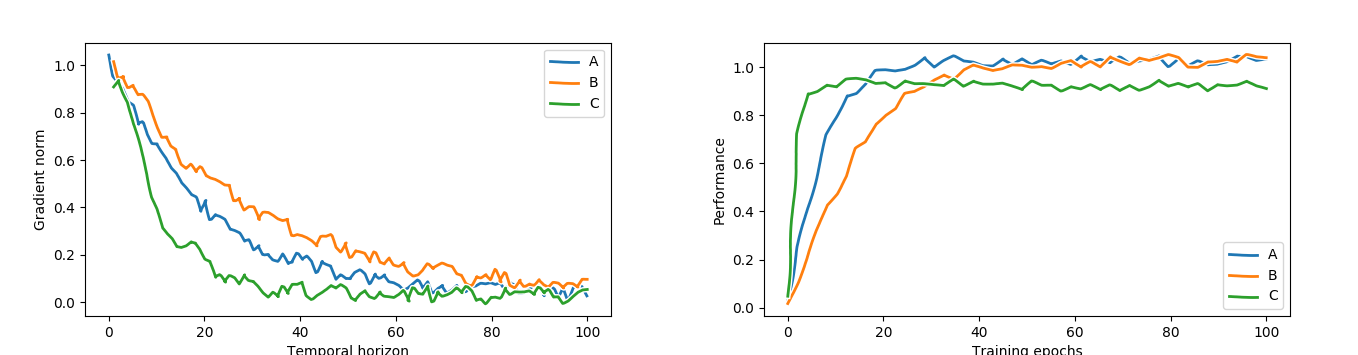

In [1]:
from IPython.display import Image, display
display(Image(filename='question_figs.png', width=850))

c.  Write down five possible Connectionist Temporal Classification (CTC) paths (of no more than a length of eight) that correspond to the same label "LADDER".